In [1]:
import numpy

# Bayesian Bootstrap

In [2]:
N, k = 20, 2
sigma = 4
beta = numpy.random.uniform(1, 10, k)
X = numpy.random.uniform(1,  10, (N, k))
X[:,0] = 1
y = numpy.dot(X, beta) + numpy.random.normal(0, sigma, N)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

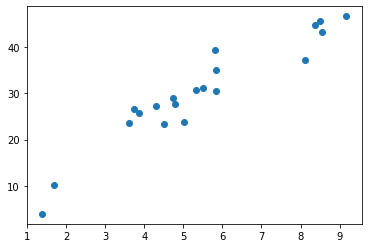

In [4]:
plt.scatter(X[:, 1], y)

In [5]:
beta

array([5.27973598, 4.43899676])

In [6]:
from sklearn.linear_model import LinearRegression

In [7]:
model = LinearRegression(fit_intercept=False).fit(X, y)

In [8]:
model.coef_

array([4.296919  , 4.79013201])

In [9]:
from sklearn.utils import resample

In [11]:
N_bs = 1000
coef = []
for _ in range(N_bs):
    coef.append(LinearRegression(fit_intercept=False).fit(*resample(X, y)).coef_)

(array([  5.,  12.,  22.,  42.,  64.,  98.,  98.,  99., 125.,  92., 107.,
         58.,  61.,  37.,  23.,  17.,  25.,   8.,   6.,   1.]),
 array([-1.83795735, -1.1004913 , -0.36302526,  0.37444079,  1.11190683,
         1.84937288,  2.58683893,  3.32430497,  4.06177102,  4.79923707,
         5.53670311,  6.27416916,  7.0116352 ,  7.74910125,  8.4865673 ,
         9.22403334,  9.96149939, 10.69896543, 11.43643148, 12.17389753,
        12.91136357]),
 <a list of 20 Patch objects>)

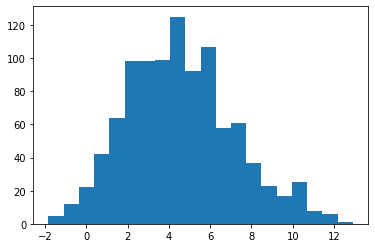

In [13]:
plt.hist([c[0] for c in coef], bins=20)

In [14]:
import statsmodels.api as stm

In [17]:
stm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     166.8
Date:                Thu, 17 Oct 2019   Prob (F-statistic):           1.53e-10
Time:                        08:30:52   Log-Likelihood:                -52.658
No. Observations:                  20   AIC:                             109.3
Df Residuals:                      18   BIC:                             111.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2969      2.164      1.986      0.063      -0.249       8.843
x1             4.7901      0.371     12.915      0.000       4.011       5.569
==============================================================================
Omnibus:                        0.333   Durbin-Watson:                   1.549
Prob(Omnibus):                  0.847   Jarque-Bera (JB):                0.121
Skew:                          -0.176   Prob(JB):                        0.941
Kurtosis:                       2.852   Cond. No.                         16.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
numpy.quantile([[c[0] for c in coef]], [0.025, 0.5, .975])

array([ 0.04312172,  4.35928423, 10.31491729])

In [20]:
numpy.quantile([[c[1] for c in coef]], [0.025, 0.5, .975])

array([3.88466524, 4.76517885, 5.65714725])

# Full Bayesian, with MCMC

In [22]:
N, k = 20, 3
sigma = 4
theta = numpy.random.uniform(1, 10, k)
X = numpy.random.uniform(1,  10, (N, k))
y = numpy.dot(X, theta) + numpy.random.normal(0, sigma, N)

We start off by taking $\sigma$ as a given and simulate $\theta$

In [106]:
thetas = []
accept = []
theta_t = numpy.ones(k)
step_size = 0.1
for _ in range(5000):
    for i in range(k):
        theta_p = theta_t.copy()
        theta_p[i] += numpy.random.normal(0, 0.1)
        alpha = numpy.exp(-(numpy.sum((y - numpy.dot(X, theta_p))**2) 
                          - numpy.sum((y - numpy.dot(X, theta_t))**2)) / sigma**2 / 2)
        if numpy.random.uniform(0, 1) <= alpha:
            theta_t = theta_p
            accept.append(True)
        else:
            accept.append(False)
    thetas.append(theta_t)

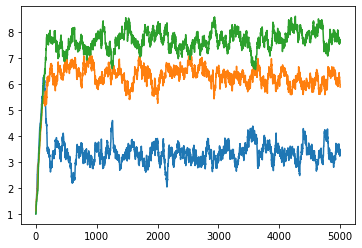

In [25]:
plt.plot(thetas)

In [113]:
# acceptance rate
# you can experiment with the step size to see what it does to
# the acceptance rate
numpy.mean(accept[500*3:])

0.8832631578947369

In [26]:
theta

array([3.01477415, 7.21168014, 7.05265419])

In [27]:
stm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                              6490.
Date:                Thu, 17 Oct 2019   Prob (F-statistic):                    3.40e-26
Time:                        08:53:43   Log-Likelihood:                         -50.151
No. Observations:                  20   AIC:                                      106.3
Df Residuals:                      17   BIC:                                      109.3
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             3.2622      0.265     12.290      0.000       2.702       3.822
x2             6.3896      0.277     23.088      0.000       5.806       6.973
x3             7.6281      0.303     25.214      0.000       6.990       8.266
==============================================================================
Omnibus:                        0.183   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.912   Jarque-Bera (JB):                0.191
Skew:                           0.175   Prob(JB):                        0.909
Kurtosis:                       2.673   Cond. No.                         5.13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The MCMC results should coincide with the OLS results.

In [28]:
for i in range(k):
    print(i, numpy.quantile([t[i] for t in thetas[500:]], [.025,.5,.975]))

0 [2.63979096 3.3175419  4.11019566]
1 [5.66539844 6.30985693 6.91585559]
2 [6.96432932 7.68915499 8.35996125]


In [29]:
fit = LinearRegression(fit_intercept=False).fit(X, y)

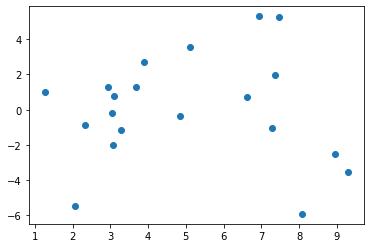

In [32]:
plt.scatter(X[:,0], fit.predict(X) - y)

## Simulating $\sigma$

MCMC is not always stable, simulating $\sigma$ brings its own set of issues.

In [129]:
thetas, sigmas, accept, accept_sigma = [], [], [], []
theta_t = numpy.ones(k)
sigma_t = 1
step_size = 0.05
for _ in range(10000):
    for i in range(k):
        theta_p = theta_t.copy()
        theta_p[i] += numpy.random.normal(0, step_size)
        alpha = numpy.exp(-(numpy.sum((y - numpy.dot(X, theta_p))**2) 
                          - numpy.sum((y - numpy.dot(X, theta_t))**2)) / sigma_t**2 / 2)
        if numpy.random.uniform(0, 1) <= alpha:
            theta_t = theta_p
            accept.append(True)
        else:
            accept.append(False)
    # choose a steps size for sigma that's a factor
    # 4 smaller than the one for theta, by experimentation
    # There are methods available that adapt the step size
    # automatically according to accept rate.
    sigma_p = sigma_t + numpy.random.normal(0, step_size/4)
    alpha = sigma_t / sigma_p * numpy.exp(-numpy.sum((y - numpy.dot(X, theta_t))**2) / sigma_p**2 / 2
                          + numpy.sum((y - numpy.dot(X, theta_t))**2) / sigma_t**2 / 2)
    if numpy.random.uniform(0, 1) <= alpha:
        sigma_t = sigma_p
        accept_sigma.append(True)
    else:
        accept_sigma.append(False)
    thetas.append(theta_t)
    sigmas.append(sigma_t)

/Users/dirk/.venv/p3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp
/Users/dirk/.venv/p3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


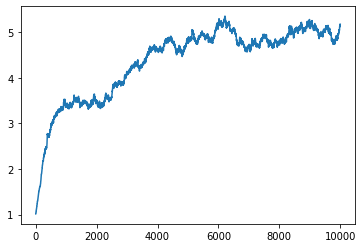

In [130]:
plt.plot(sigmas)

In [131]:
numpy.mean(accept_sigma[5000:])

0.9928

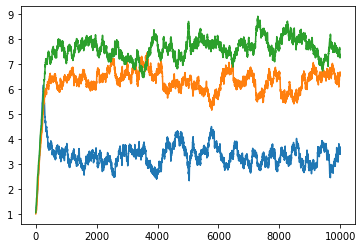

In [132]:
plt.plot(thetas)

In [133]:
numpy.mean(accept[5000*3:])

0.9121333333333334

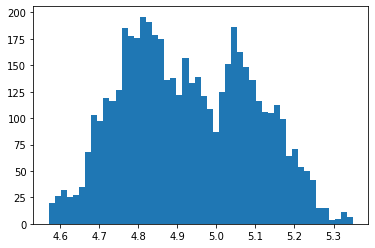

In [134]:
plt.hist(sigmas[5000:], bins=50)
None

In [51]:
for i in range(k):
    print(i, numpy.quantile([t[i] for t in thetas[1000:]], [.025,.5,.975]))

0 [2.73530895 3.19330392 3.73411344]
1 [5.90406316 6.47777005 7.07848784]
2 [6.90765944 7.58556953 8.35045567]


In [52]:
stm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                              6490.
Date:                Thu, 17 Oct 2019   Prob (F-statistic):                    3.40e-26
Time:                        09:27:12   Log-Likelihood:                         -50.151
No. Observations:                  20   AIC:                                      106.3
Df Residuals:                      17   BIC:                                      109.3
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             3.2622      0.265     12.290      0.000       2.702       3.822
x2             6.3896      0.277     23.088      0.000       5.806       6.973
x3             7.6281      0.303     25.214      0.000       6.990       8.266
==============================================================================
Omnibus:                        0.183   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.912   Jarque-Bera (JB):                0.191
Skew:                           0.175   Prob(JB):                        0.909
Kurtosis:                       2.673   Cond. No.                         5.13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
numpy.quantile(sigmas[5000:], [.025,.5,.975])

array([3.67166195, 3.90787114, 4.196883  ])

# Stan

In [ ]:
# conda install pystan cython

In [55]:
import pystan

In [60]:
lr_code = """
data {
    int<lower=0> N;
    int<lower=0> k;
    matrix[N, k] X;
    vector[N] y;
}
parameters {
    vector[k] theta;
    real<lower=0> sigma;
}
model {
    y ~ normal(X * theta, sigma);
}
"""

In [61]:
lr_model = pystan.StanModel(model_code=lr_code)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8f8df8368adedfbaba78a2b6f661755d NOW.


In [63]:
fit = lr_model.sampling(data={'X': X, 'y': y, 'N': N, 'k': k}, iter=1000, chains=4)

In [64]:
results = fit.extract(['theta', 'sigma'])

In [65]:
print(fit)

Inference for Stan model: anon_model_8f8df8368adedfbaba78a2b6f661755d.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]   3.26  7.9e-3    0.3   2.64   3.07   3.27   3.46   3.84   1468    1.0
theta[2]   6.38  9.3e-3   0.32   5.73   6.17   6.38   6.58   7.02   1178    1.0
theta[3]   7.64    0.01   0.35   6.97   7.43   7.63   7.86   8.36   1139    1.0
sigma      3.51    0.02   0.66   2.49   3.06   3.42   3.87   5.06   1041    1.0
lp__     -33.02    0.06   1.65 -37.43 -33.82  -32.7 -31.82 -30.96    659   1.01

Samples were drawn using NUTS at Thu Oct 17 09:39:58 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


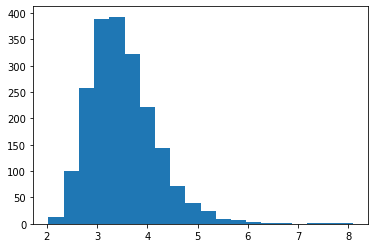

In [67]:
plt.hist(results['sigma'], bins=20)
None

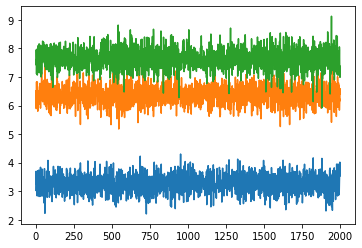

In [69]:
plt.plot(results['theta'])
None

In [70]:
import pandas

In [71]:
batting_data = pandas.read_csv('data/bats.txt', sep='\t')

In [72]:
batting_data

,FirstName,LastName,At-Bats,Hits,BattingAverage,RemainingAt-Bats,RemainingAverage,SeasonAt-Bats,SeasonHits,SeasonAverage
0,Roberto,Clemente,45,18,0.400,367,0.3460,412,145,0.352
1,Frank,Robinson,45,17,0.378,426,0.2981,471,144,0.306
2,Frank,Howard,45,16,0.356,521,0.2764,566,160,0.283
3,Jay,Johnstone,45,15,0.333,275,0.2218,320,76,0.238
4,Ken,Berry,45,14,0.311,418,0.2727,463,128,0.276
5,Jim,Spencer,45,14,0.311,466,0.2704,511,140,0.274
6,Don,Kessinger,45,13,0.289,586,0.2645,631,168,0.266
7,Luis,Alvarado,45,12,0.267,138,0.2101,183,41,0.224
8,Ron,Santo,45,11,0.244,510,0.2686,555,148,0.267
9,Ron,Swaboda,45,11,0.244,200,0.2300,245,57,0.233


In [75]:
binomial_code = """
data {
    int<lower=0> N;
    int<lower=0> k[N]; // at bats
    int<lower=0> y[N]; // successes
}
parameters {
    vector<lower=0, upper=1>[N] phi;
}
model {
    y ~ binomial(k, phi);
}
"""

In [76]:
b_model = pystan.StanModel(model_code=binomial_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9bea96e3c535cc10c969a91dd58519db NOW.


In [81]:
b_fit = b_model.sampling(data={'N': batting_data.shape[0], 'k': batting_data['At-Bats'], 'y': batting_data['Hits']},
                    iter=1000, chains=4)

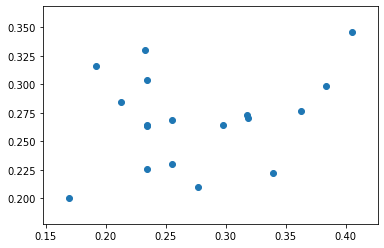

In [84]:
plt.scatter(b_fit.extract()['phi'].mean(axis=0), batting_data['RemainingAverage'])

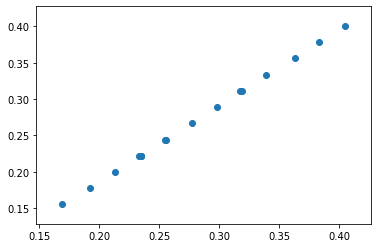

In [85]:
plt.scatter(b_fit.extract()['phi'].mean(axis=0), batting_data['BattingAverage'])

# Data Pooling

We have a hyperprior

$$\kappa \sim \operatorname{pareto}(1, 1.5)\,,$$

a prior

$$\phi \sim \operatorname{beta}(\theta\,\kappa, (1-\theta)\,\kappa)\,,$$

and the likelihood

$$y \sim \operatorname{binomial}(k, \phi)$$


In [87]:
pooled_code = """
data {
    int<lower=0> N;
    int<lower=0> k[N]; // at bats
    int<lower=0> y[N]; // successes
}
parameters {
    real<lower=0, upper=1> theta; // population chance of success
    real <lower=1> kappa; // concentration or amount of pooling
    vector<lower=0, upper=1>[N] phi; // per-player chance of success
}
model {
    kappa ~ pareto(1, 1.5); // hyper prior
    phi ~ beta(theta * kappa, (1 - theta)*kappa); // prior
    y ~ binomial(k, phi); // likelihood
}
"""

In [88]:
pooled_model = pystan.StanModel(model_code=pooled_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_af1158bf590fabbd53f0dbe57872f180 NOW.


In [93]:
pooled_fit = pooled_model.sampling(data={'N': batting_data.shape[0], 'k': batting_data['At-Bats'], 'y': batting_data['Hits']},
                                  iter=1000, chains=4, control={'adapt_delta': 0.99, 'stepsize': 0.01})

In [94]:
print(pooled_fit)

Inference for Stan model: anon_model_af1158bf590fabbd53f0dbe57872f180.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta     0.27  6.6e-4   0.02   0.23   0.25   0.27   0.28   0.31    953    1.0
kappa   104.26   11.55 213.01  15.77   37.7   61.1 110.67  427.6    340   1.01
phi[1]    0.32  1.8e-3   0.05   0.24   0.28   0.32   0.35   0.43    779    1.0
phi[2]    0.31  1.5e-3   0.05   0.22   0.28   0.31   0.34   0.42   1113    1.0
phi[3]     0.3  1.2e-3   0.05   0.22   0.27    0.3   0.33   0.41   1531    1.0
phi[4]    0.29  1.1e-3   0.05   0.21   0.26   0.29   0.32    0.4   1918    1.0
phi[5]    0.28  9.9e-4   0.05    0.2   0.25   0.28   0.31   0.39   2204    1.0
phi[6]    0.28  1.0e-3   0.05    0.2   0.25   0.28   0.31   0.39   1968    1.0
phi[7]    0.28  9.8e-4   0.04    0.2   0.25   0.28   0.31   0.37   2079    1.0
phi[8]    0.27  9.1e-4 

In [98]:
print(b_fit)

Inference for Stan model: anon_model_9bea96e3c535cc10c969a91dd58519db.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
phi[1]    0.41  1.1e-3   0.07   0.27   0.36    0.4   0.45   0.55   4442    1.0
phi[2]    0.38  1.1e-3   0.07   0.25   0.33   0.38   0.43   0.53   3864    1.0
phi[3]    0.36  1.1e-3   0.07   0.23   0.31   0.36   0.41    0.5   4257    1.0
phi[4]    0.34  1.0e-3   0.07   0.22   0.29   0.34   0.38   0.47   4213    1.0
phi[5]    0.32  1.1e-3   0.07   0.19   0.27   0.31   0.36   0.45   4070    1.0
phi[6]    0.32  9.8e-4   0.07    0.2   0.27   0.32   0.37   0.46   5014    1.0
phi[7]     0.3  1.0e-3   0.07   0.17   0.25    0.3   0.34   0.44   4151    1.0
phi[8]    0.28  9.9e-4   0.06   0.16   0.23   0.27   0.32   0.41   4148    1.0
phi[9]    0.26  9.4e-4   0.06   0.14   0.21   0.25   0.29   0.38   4228    1.0
phi[10]   0.26  1.0e-3 

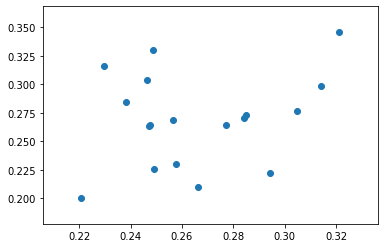

In [100]:
plt.scatter(pooled_fit.extract()['phi'].mean(axis=0), batting_data['RemainingAverage'])

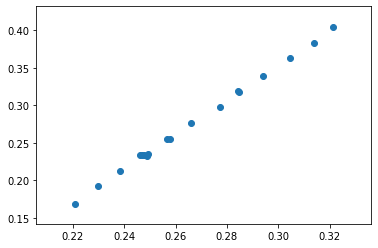

In [97]:
plt.scatter(pooled_fit.extract()['phi'].mean(axis=0), b_fit.extract()['phi'].mean(axis=0))

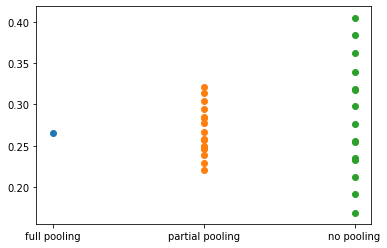

In [105]:
plt.scatter([0], [batting_data['BattingAverage'].mean()])
plt.scatter([1]*batting_data.shape[0], pooled_fit.extract()['phi'].mean(axis=0))
plt.scatter([2]*batting_data.shape[0], b_fit.extract()['phi'].mean(axis=0))
plt.xticks([0, 1, 2], ['full pooling', 'partial pooling', 'no pooling'])
None